# Contexte du projet

Ce brief a pour objectif d’appliquer le Transfer Learning sur une base de données.

Dans ce brief, nous appliquons un apprentissage supervisé pour identifier si la personne porte un masque ou non.

​
NB. Utiliser le Colab pour l'apprentissage du modèle (https://colab.research.google.com/?hl=fr)

​

## Challenges
​
Maitriser la manipulation des images.


Manipulation et l’exploitation de la Bibliothèque Keras.


Charger un modèle CNN à partir de Keras.


Appliquer le Transfer Learning (sur VGG16).


Faire des tests à partir de la webcam

​

# Les étapes du brief

​

## Partie 1 : Base de données, Analyse et Préparation

​

Pour aborder cette problématique, il est primordial d’avoir une DataSet. Pour cela, la DataSet se trouve sur : https://drive.google.com/drive/folders/1HOxFk8alSSMshf95ToLEUuYZ1Ki7p90Q?usp=sharing

​

Par la suite, il faut développer les étapes suivantes :

– Charger les images.

– Penser à redimensionner les images selon le modèle VGG16.

– Appliquer la préparation des données nécessaire pour le modèle VGG16.

– Splitter les données en données d’apprentissage, validation et test.

– Visualiser les images de la classe Avec_Masque et Sans_Masque.

​

## Partie 2 : Architecture CNN sur Keras

​

Cette deuxième partie est réservée pour développer le modèle CNN sur Keras, et lancée par la suite l’apprentissage de CNN.

Au début, il faut préparer et appliquer la Data Augmentation sur les données d’apprentissage.
Charger et configurer le modèle VGG16 pour l’application souhaitée.
Appeler le ModelCheckpoint pour sauvgarder le meilleurs modèle durant l’apprentissage (from keras.callbacks import ModelCheckpoint)


Lancer un apprentissage en utilisant les données d’apprentissage et les données de validation avec un historique.
Tracer les courbes d’accuracy et d’erreur de train et validation.
Calculer l’accuracy et la matrice de confusion sur les données de test.


## Partie 3 : Application


Nous cherchons à tester le modèle développé sur des nouvelles images.

​Pour un début, cherchez des images sur le net ou prenez photos entre vous et tester le résultat de votre modèle en affichant le message : Avec masque ou Non masque sur l’image.

    (cv2.putText(Img, message, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0)))

Par la suite, vous êtes censés à développer un code python qui va activer la Webcam et identifier si la personne qui est devant la Webcam porte un masque ou non en affichant le message : Avec masque ou Non masque sur l’image.


# Code

mur des import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

2023-09-14 14:36:55.111644: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 14:36:55.320000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 14:36:55.320670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 14:36:56.450193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Partie 1 : Base de données, Analyse et Préparation

In [2]:
dataset_path = './Mask_Data-20230914T090722Z-001/Mask_Data/'

#### creation de 2 classe de sortie su model 

    without_mask , with_mask

In [3]:
class_name = choice(['without_mask', 'with_mask'])
class_path = os.path.join(dataset_path, class_name)

### afichage d'une image prise de facon aleatoire

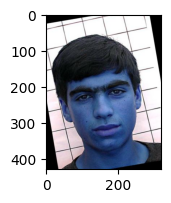

In [4]:
image_name = choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Read and Display the random image
image = cv2.imread(image_path)
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

### prepatation des data pour l'entrainement et la validation

In [5]:
# biblioteque d'aplicatif pour les données  d'entraînement 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# biblioteque d'aplicatif pour les données de validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# générateurs de données d'entraînement et de validation suplementaire
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_mask', 'with_mask'])

val_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_mask', 'with_mask'],
    shuffle=False)

Found 1508 images belonging to 2 classes.
Found 1508 images belonging to 2 classes.


## Partie2 : Architecture CNN sur Keras

### importaion du model (VGG16) pré-entrainé

In [6]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### entrainement "oui non"
donné la posibilté ou non,  de ré'entrainé le reseau de nerone du model "vgg16" 

si "non" l'entrenement se passera uniquement sur les couche du reseau de neurone que l'on va ajouté 


    True = entrainement sur tout le reseau de nerone (peu demandé baucoup plus de resource)
    False = le reseau de nerone est gelé et uniquement les couches ajouté seront entrainé

In [7]:
for layer in vgg16.layers:
    layer.trainable = False
    #layer.trainable = True

### ajout de couche neuronal au model

Dense pour ajouter 2 couche de nerone au modèle

model qui doit etre unidimensionnel pour utilisé "Dense"


utilisation de flatten pour aplatir la sortie du modèle et donc le rendre unidimensionelle.

(la dernierre couche ajoute 1 neurone car on a 2 classe et donc une sortie booleene True,False est possible)

In [8]:
from keras.layers import Dense, Flatten
from keras.models import Model


# Add a new fully connected layer
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create a new model
model = Model(inputs=vgg16.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', save_best_only=True, mode='max', verbose=1)


### entrainement du model

In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=7,
    callbacks=[checkpoint] #save du meilleur model
)


# 4minutes in T4googleColab
# loss: 0.0056 - accuracy: 0.9993 - val_loss: 0.0046 - val_accuracy: 0.9993

Epoch 1/4


2023-09-14 14:36:59.711677: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-09-14 14:36:59.851286: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-09-14 14:37:00.484650: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-09-14 14:37:00.587043: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2023-09-14 14:37:00.791564: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


47/47 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.8997
Epoch 1: accuracy improved from -inf to 0.89973, saving model to best_model.h5


/home/coulm/clone/detection_masque/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 287s 6s/step - loss: 0.5451 - accuracy: 0.8997 - val_loss: 0.0228 - val_accuracy: 0.9914
Epoch 2/4
47/47 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9878
Epoch 2: accuracy improved from 0.89973 to 0.98780, saving model to best_model.h5
47/47 [==============================] - 277s 6s/step - loss: 0.0331 - accuracy: 0.9878 - val_loss: 0.0192 - val_accuracy: 0.9947
Epoch 3/4
47/47 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9919
Epoch 3: accuracy improved from 0.98780 to 0.99187, saving model to best_model.h5
47/47 [==============================] - 276s 6s/step - loss: 0.0240 - accuracy: 0.9919 - val_loss: 0.0079 - val_accuracy: 0.9980
Epoch 4/4
47/47 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9878
Epoch 4: accuracy did not improve from 0.99187
47/47 [==============================] - 278s 6s/step - loss: 0.0358 - accuracy: 0.9878 - val_loss: 0.0046 - val_accurac

### Suivi des epochs


affiche grafiquement l'evolution de l'accuracy et de la perte du modèle au fil des epochs 



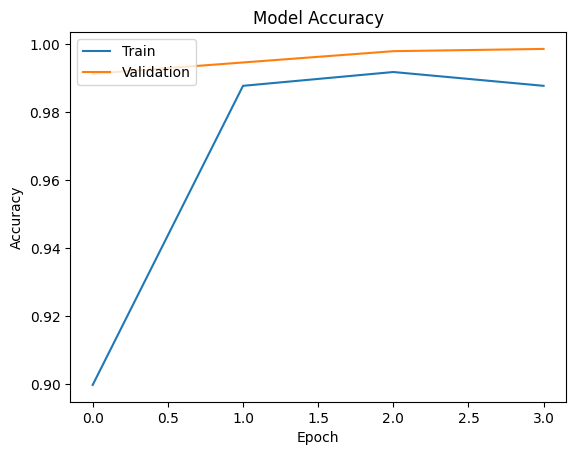

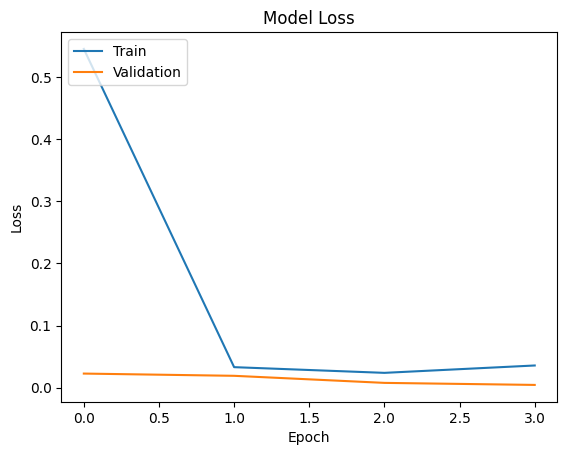

In [11]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
def preprocess_image_to_test(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Resize the image while maintaining its aspect ratio
    h, w, _ = image.shape
    if h > w:
        ratio = 224 / h
    else:
        ratio = 224 / w
    resized_img = cv2.resize(image, (int(w * ratio), int(h * ratio)), interpolation=cv2.INTER_AREA)

    # Add padding to make the image 224x224
    h, w, _ = resized_img.shape
    pad_h = (224 - h) // 2
    pad_w = (224 - w) // 2
    padded_img = cv2.copyMakeBorder(resized_img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT)

    # Preprocess the image
    image = np.expand_dims(padded_img, axis=0)
    image = image / 255.0

    # Resize the image to (224, 224, 3)
    image = cv2.resize(image[0], (224, 224), interpolation=cv2.INTER_AREA)
    image = np.expand_dims(image, axis=0)

    return image

In [13]:
import joblib
joblib.dump(model,'./model.pkl')


['./model.pkl']

## Partie 3 : Application

### lot d'image de test pour la prediction du model

In [14]:
test_path = './Mask_Data-20230914T090722Z-001/test/'
# Load some images to test
test01 = preprocess_image_to_test(f'{test_path }/2023-09-14-124411.jpg')
test02 = preprocess_image_to_test(f'{test_path }/2023-09-14-124412.jpg')


normalisaion des image de test 

In [15]:
test02.shape


(1, 224, 224, 3)

exemple de shape attendu

    (1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


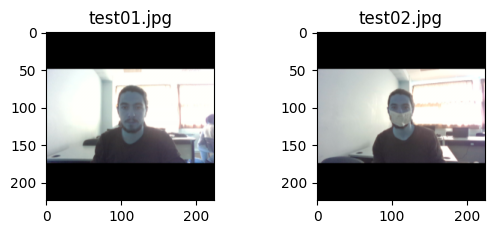

In [16]:
# Display the test images
plt.subplot(2, 2, 1)
plt.imshow(test01[0])
plt.title('test01.jpg')

plt.subplot(2, 2, 2)
plt.imshow(test02[0])
plt.title('test02.jpg')



plt.show()

### Prediction

In [17]:
# Make predictions
prediction01 = model.predict(test01)
prediction02 = model.predict(test02)

print()

# Print the predictions
if prediction01 < 0.5:
    print('The person in test01.jpg is not wearing a mask.')
else:
    print('The person in test01.jpg is wearing a mask.')

if prediction02 < 0.5:
    print('The person in test02.jpg is not wearing a mask.')
else:
    print('The person in test02.jpg is wearing a mask.')


1/1 [==============================] - 0s 128ms/step

The person in test01.jpg is wearing a mask.
The person in test02.jpg is wearing a mask.
